In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os, random
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestCentroid
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from scipy.signal import savgol_filter
from scipy import interpolate
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
np.random.seed( 0 )
sns.set_style( "darkgrid" )


In [36]:
df = pd.read_parquet('C:/Users/lselig/selig-fa/finance/.data/fundamental_analysis_neglog.parquet')
df = df[(df.period == "Q2") & (df.calendarYear == "2022")]
print(df.columns)
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df.dropna(axis=0, inplace = True)
df = df.drop_duplicates()
targets = df.wk_curr_to_next_pct_inc.values

targets_binary = targets >= 1.0 # bools
targets_binary = np.array(targets_binary, dtype = "int")
plt.close()
plt.bar(targets_binary)
plt.show()


print(targets_binary)
tickers = df.symbol.values
periods = df.period.values
calendarYears = df.calendarYear.values
date = df.date.values
qualitative_data = np.array((tickers, periods, calendarYears, date)).T
df = df.drop(columns = ["period", "calendarYear", "symbol", "date", "open_next", "wk_curr_to_next_pct_inc"])
features = df.to_numpy()
print(targets.shape, features.shape)

Index(['symbol', 'calendarYear', 'period', 'revenue', 'costOfRevenue',
       'grossProfit', 'grossProfitRatio', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       ...
       'netDebt', 'open_on', 'volume_on', 'vwap_on', 'open_next', 'open_prev',
       'volume_prev', 'vwap_prev', 'wk_curr_to_next_pct_inc',
       'wk_prev_to_curr_pct_inc'],
      dtype='object', length=115)


TypeError: bar() missing 1 required positional argument: 'height'

In [ ]:
scaler = StandardScaler()
features =  scaler.fit_transform(features)
features = np.clip(features, -5, 5)
print(features.shape)
n_features = features.shape[1]
print(n_features)
%matplotlib widget 
for i in range(n_features):
    print(i, np.nanmin(features[:, i]), np.nanmax(features[:, i]))
    sns.kdeplot(features[:, i])
plt.title("Distribution of final features")

In [ ]:
print(list(df))
print(features.shape, targets.shape)


In [ ]:
pca = PCA(n_components=2)
pca.fit(features.T)
print(pca.explained_variance_ratio_)
print(np.sum(pca.explained_variance_ratio_))
# print(pca.singular_values_)
# print(components)
# plt.hist2d(components[:, 0], components[:, 1], bins = 50)
components = pca.components_.T
print(components.shape)
# components[0,:]
plt.close()
plt.hist2d(components[:, 0], components[:, 1], bins = 60)
plt.show()
# plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation

clst = KMeans(n_clusters=3, random_state=0).fit(components)
# clst = AffinityPropagation( random_state=0).fit(components)
labels = clst.labels_.reshape(-1, 1)
pca_and_labels = np.hstack((components, labels))
print(pca_and_labels.shape)
clst.labels_.shape
fig, axs = plt.subplots(1, 2, figsize = (12, 8))
for g in np.unique(labels):
    idxs = np.where(pca_and_labels[:, 2] == g)[0]
    cluster = pca_and_labels[idxs]
    for i, c in enumerate(cluster):
        print(c[0], c[1], qualitative_data[:, 0][idxs[i]])
        axs[0].text(c[0], c[1], s = qualitative_data[:, 0][idxs[i]])
    axs[0].scatter(cluster[:, 0],  cluster[:, 1], label = g)
axs[0].set_xlabel("PCA1")
axs[0].set_ylabel("PCA2")
axs[1].hist2d(pca_and_labels[:, 0], pca_and_labels[:, 1], bins = 40)
axs[1].set_xlabel("PCA1")
axs[1].set_ylabel("PCA2")
axs[0].legend()
plt.show()

    
# plt.scatter(pca_and_labels[:, 0], pca_and_labels[: ,1], group = )
# plt.close()
# plt.hist(kmeans.labels_)
# plt.show()


In [ ]:
# the tickers where PCA2 is an outlier are all related to Federal National Mortgage Association (FNMA)
# not sure if it can be exploited
interesting = np.argwhere(pca_and_labels[: ,1] >= 0.08)
interesting_tickers = tickers[interesting]
# print(interesting_tickers)

interesting = np.argwhere(pca_and_labels[: ,1] <= -0.0365)
interesting_tickers = tickers[interesting]
print(interesting_tickers)

In [ ]:

interesting = np.argwhere(pca_and_labels[: ,0] >= 0.0055)
interesting_tickers = qualitative_data[interesting]
print(interesting_tickers)


In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

plt.close()
# good = np.where(targets <= 100)[0]
corrs = [] 
for i in range(n_features):
    f = features[:, i]
    t = targets
    r = np.corrcoef(f, t)[0, 1]
    corrs.append(r)

sns.kdeplot(corrs)

X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_train)
print(mean_absolute_error(y_pred, y_train))
print(r2_score(y_pred, y_train))



NameError: name 'n_features' is not defined

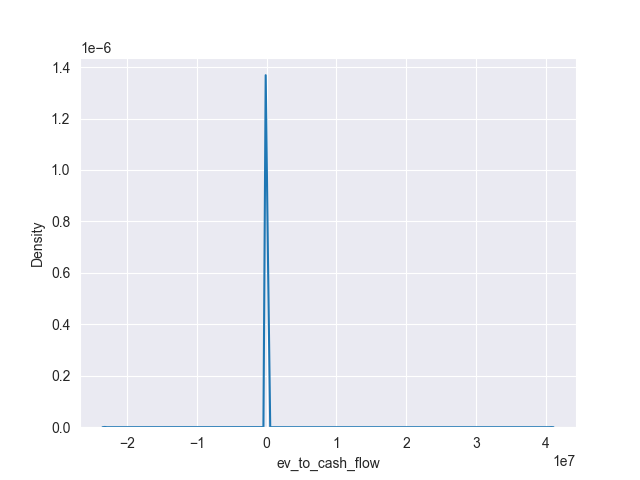

pfcf_ratio
pb_ratio
ev_sales
ev_over_ebitda
ev_to_cash_flow
earnings_yield
free_cash_flow_yield
debt_to_equity
debt_to_assets
current_ratio
(8698,) (8698, 118)


In [16]:
# df = pd.read_parquet('C:/Users/lselig/selig-fa/finance/.data/fundamental_analysis_neglog.parquet')
df = pd.read_parquet('C:/Users/lselig/selig-fa/finance/.data/fundamental_analysis.parquet')
# df = df[(df.period == "Q2") & (df.calendarYear == "2022")]
df = df[(df.calendarYear == "2022")]
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df.dropna(axis=0, inplace = True)
df = df.drop_duplicates()
# targets = df.wk_curr_to_next_pct_inc.values
targets = df.open_next.values
# targets = df.open_prev.values
# targets = df.open_on.values
# targets_binary = targets >= 1.0 # bools
# targets_binary = np.array(targets_binary, dtype = "int")
tickers = df.symbol.values
periods = df.period.values
calendarYears = df.calendarYear.values
date = df.date.values
qualitative_data = np.array((tickers, periods, calendarYears, date)).T
current_ratio = df.totalCurrentAssets / df.totalCurrentLiabilities
df["share_number"] = df.commonStock + df.preferredStock
market_cap = (df.share_number) * df.open_on
enterprise_value = market_cap - df.cashAndCashEquivalents + df.totalDebt

ratios = ["pe_ratio", "ps_ratio", "pcf_ratio", "pfcf_ratio",
          "pb_ratio", "ev_sales", "ev_over_ebitda", "ev_to_cash_flow",
          "earnings_yield", "free_cash_flow_yield", "debt_to_equity",
          "debt_to_assets", "current_ratio"]
price = df.open_prev
df["pe_ratio"] = price / (df.netIncome_x / df.share_number)
df["ps_ratio"] = price / (df.revenue / df.share_number)
df["pcf_ratio"] = price / (df.operatingCashFlow / df.share_number)
df["pfcf_ratio"] = market_cap / df.freeCashFlow
df["pb_ratio"] = price  / (df.totalStockholdersEquity / df.share_number)
df["ev_sales"] = enterprise_value / df.revenue
df["ev_over_ebitda"] = enterprise_value / df.ebitda
df["ev_to_cash_flow"] = enterprise_value / df.operatingCashFlow
df["earnings_yield"] = (df.netIncome_x / df.share_number) / price
df["free_cash_flow_yield"] = df.freeCashFlow / market_cap
df["debt_to_equity"] = df.longTermDebt / df.totalStockholdersEquity
df["debt_to_assets"] = df.longTermDebt / df.totalAssets
df["current_ratio"] = df.totalCurrentAssets / df.totalCurrentLiabilities

i = 7
plt.close()
sns.kdeplot(df[ratios[i]])
plt.show()

df = df.drop(columns = ["vwap_on", "vwap_prev", "open_on", "open_prev", "period",
                        "calendarYear", "symbol", "date", "open_next", "wk_curr_to_next_pct_inc",
                        "wk_prev_to_curr_pct_inc"])

for x in df.columns[-10:]:
    print(x)
features = df.to_numpy()
print(targets.shape, features.shape)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

reg = LinearRegression().fit(X_train, y_train)
y_pred = reg.predict(X_test)
print(mean_absolute_error(y_pred, y_test))
print(r2_score(y_test, y_pred))
print(y_pred)
for i in range(features.shape[1]):

    r = np.corrcoef(features[:, i], targets)[0, 1]
    print(np.round(r, 4))
    

(6958, 104) (1740, 104) (6958,) (1740,)
819.6352088941937
-60.777549115936296
[ -401.58550125 -1536.39520236  1116.16162306 ...  -840.08039607
  -825.7737531   -555.8058981 ]
0.0214
-0.0126
-0.0025
0.0002
-0.0088
0.0165
0.0252
0.018
0.0006
-0.0159
0.0116
0.022
0.0212
0.0222
0.0199
0.0049
0.0017
0.0055
0.0204
0.0122
0.0056
0.011
0.0156
0.0055
0.0511
0.0523
-0.011
-0.0111
0.0161
0.0217
-0.0011
-0.0156
-0.006
-0.0189
0.0029
-0.006
0.0159
0.0089
0.0232
-0.019
-0.0248
-0.0355
0.0361
0.0203
-0.0134
-0.0231
0.0063
-0.0347
-0.0031
0.0179
0.0176
0.0233
-0.0072
0.0244
0.0262
0.0232
-0.0156
0.0244
0.0247
0.0213
0.0252
0.0192
-0.0087
-0.0244
-0.0282
0.0139
0.0183
0.017
0.0151
0.0211
-0.0048
-0.013
0.0104
0.0349
0.0273
0.0136
0.0211
0.0009
-0.0076
-0.0209
0.0188
0.0196
-0.0036
0.0318
-0.0078
0.0198
0.0318
-0.0122
0.027
-0.0037
0.0018
0.0225
-0.0165
-0.0154
0.0142
0.0247
0.0191
0.0132
0.0273
0.0384
0.0191
0.0184
-0.013
-0.0107


In [34]:
clf = RandomForestClassifier(max_depth=4, random_state=0)
print(targets_binary)
X_train, X_test, y_train, y_test = train_test_split(features, targets_binary, test_size = 0.2, random_state = 42)
print(y_train)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
print(y_pred)
print(classification_report(y_pred, y_train))

[1 1 0 ... 1 1 0]
[0 1 0 ... 0 0 1]
[1 1 1 ... 1 1 1]
              precision    recall  f1-score   support

           0       0.11      1.00      0.19        45
           1       1.00      0.66      0.79      1087

    accuracy                           0.67      1132
   macro avg       0.55      0.83      0.49      1132
weighted avg       0.96      0.67      0.77      1132

